Ressources :
- https://netcarbon.notion.site/Senior-Data-engineer-exercice-ee2f44d703804eb68a42bfb819b45dca
- https://www.agricolus.com/en/vegetation-indices-ndvi-ndmi/
- https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/
- https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#

In [1]:
%matplotlib inline

import shapely
import pandas as pd
import geopandas as gpd
import contextily as cx
import rich.table
import xarray as xr
from random import choice
from rasterio.features import geometry_mask
from matplotlib import pyplot as plt
from pystac_client import Client
from shapely import wkt
from odc.stac import stac_load

In [2]:
tournesol_df = pd.read_csv('../sampled_rpg_data/tournesol.csv')
maize_df = pd.read_csv('../sampled_rpg_data/maize.csv')
rpg_df = pd.concat([tournesol_df, maize_df])
rpg_df['geometry'] = rpg_df['geometry'].apply(wkt.loads)

In [3]:
rpg_gdf = gpd.GeoDataFrame(rpg_df, crs='epsg:2154').to_crs(crs='epsg:4326')
rpg_gdf.head()

,Unnamed: 0,ID_PARCEL_2022,SURF_PARC_2022,CODE_CULTU_2022,CODE_GROUP_2022,CULTURE_D1_2022,CULTURE_D2_2022,geometry,libelle_cultu_2022,CAMPAGNE_DEBUT_2022,CAMPAGNE_FIN_2022,libelle_d1_2022,libelle_d2_2022,area
0,187842,1133906,9.71,TRN,6,NaN,NaN,"POLYGON ((0.97091 43.54035, 0.97132 43.54032, ...",Tournesol,2015,NaN,NaN,NaN,97114.949260
1,139550,841881,3.76,TRN,6,NaN,NaN,"POLYGON ((1.97183 43.86112, 1.97183 43.86112, ...",Tournesol,2015,NaN,NaN,NaN,37550.814191
2,1564874,9453515,3.38,TRN,6,NaN,NaN,"POLYGON ((1.09581 43.7644, 1.09581 43.7644, 1....",Tournesol,2015,NaN,NaN,NaN,33768.372757
3,1036094,6261084,0.94,TRN,6,NaN,NaN,"POLYGON ((0.34178 43.29936, 0.34089 43.29935, ...",Tournesol,2015,NaN,NaN,NaN,9369.597735
4,1169290,7064460,0.58,TRN,6,NaN,NaN,"POLYGON ((0.32516 43.83757, 0.32468 43.83785, ...",Tournesol,2015,NaN,NaN,NaN,5755.995216


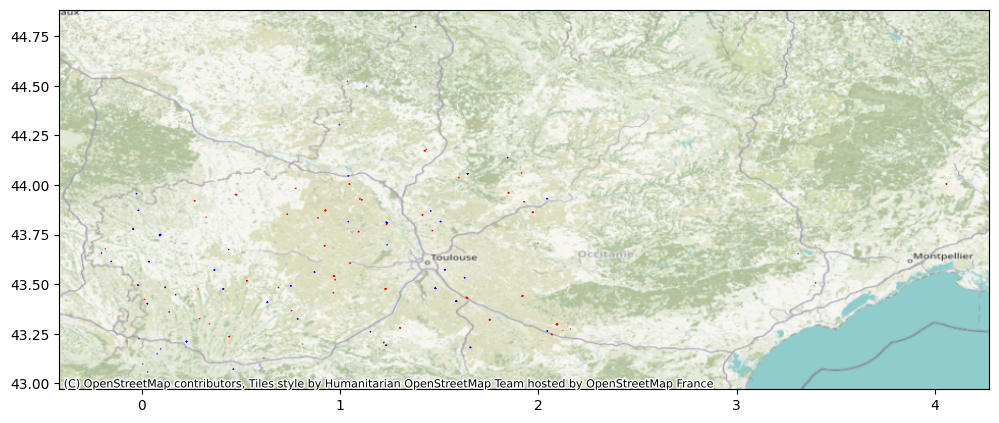

In [4]:
ax = rpg_gdf[rpg_gdf["CODE_CULTU_2022"] == "TRN"].plot(figsize=(12, 12), edgecolor='red')
rpg_gdf[rpg_gdf["CODE_CULTU_2022"] == "MIS"].plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax, crs=rpg_gdf.crs)

In [5]:
catalog = Client.open("https://earth-search.aws.element84.com/v1/")

In [6]:
multi_poly_for_sentinel_2_query = shapely.geometry.MultiPolygon(rpg_gdf.geometry.values)
query = catalog.search(collections=["sentinel-2-l2a"], datetime="2023-01-01/2023-12-31", limit=100, intersects=multi_poly_for_sentinel_2_query)

In [7]:
items = query.item_collection()
len(items)

967

In [8]:
sentinel_gdf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='epsg:4326')
sentinel_gdf

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:datastrip_id,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated
0,"POLYGON ((-0.5337 43.32625, -0.57269 42.33838,...",2023-12-31T17:06:23.845Z,sentinel-2a,sentinel-2,[msi],96.394211,32630,30,T,YN,...,S2A_OPER_MSI_L2A_DS_2APS_20231231T152149_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231231T152149_A0445...,1.034038,2023-12-31T10:59:13.800000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/30/T/Y...,roda-sentinel2/workflow-sentinel2-to-stac/0267...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-31T17:06:23.845Z
1,"POLYGON ((0.53323 43.32624, 0.57223 42.33837, ...",2023-12-31T17:10:12.030Z,sentinel-2a,sentinel-2,[msi],90.729934,32631,31,T,CH,...,S2A_OPER_MSI_L2A_DS_2APS_20231231T152149_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231231T152149_A0445...,1.034038,2023-12-31T10:59:09.914000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/C...,roda-sentinel2/workflow-sentinel2-to-stac/b3d1...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-31T17:10:12.030Z
2,"POLYGON ((1.76571 43.34619, 1.78522 42.35855, ...",2023-12-31T17:08:00.891Z,sentinel-2a,sentinel-2,[msi],84.118253,32631,31,T,DH,...,S2A_OPER_MSI_L2A_DS_2APS_20231231T152149_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231231T152149_A0445...,1.034038,2023-12-31T10:59:05.593000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/D...,roda-sentinel2/workflow-sentinel2-to-stac/eee7...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-31T17:08:00.891Z
3,"POLYGON ((-0.49642 44.22597, -0.53725 43.23828...",2023-12-31T17:41:23.733Z,sentinel-2a,sentinel-2,[msi],93.829376,32630,30,T,YP,...,S2A_OPER_MSI_L2A_DS_2APS_20231231T152149_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231231T152149_A0445...,1.034038,2023-12-31T10:58:59.043000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/30/T/Y...,roda-sentinel2/workflow-sentinel2-to-stac/ddba...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-31T17:41:23.733Z
4,"POLYGON ((0.49594 44.22596, 0.53678 43.23827, ...",2023-12-31T17:11:52.237Z,sentinel-2a,sentinel-2,[msi],98.205370,32631,31,T,CJ,...,S2A_OPER_MSI_L2A_DS_2APS_20231231T152149_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231231T152149_A0445...,1.034038,2023-12-31T10:58:55.714000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/C...,roda-sentinel2/workflow-sentinel2-to-stac/0f14...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-31T17:11:52.237Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,"POLYGON ((1.51831 43.34325, 1.88707 43.34743, ...",2023-01-02T19:10:35.393Z,sentinel-2a,sentinel-2,[msi],98.896480,32631,31,T,CH,...,S2A_OPER_MSI_L2A_DS_2APS_20230102T155200_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230102T155200_A0393...,1.034186,2023-01-02T10:49:14.804000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/C...,roda-sentinel2/workflow-sentinel2-to-stac/7776...,True,{'sentinel2-to-stac': '0.1.0'},2023-01-02T19:10:35.393Z
963,"POLYGON ((1.76571 43.34619, 3.12042 43.35278, ...",2023-01-02T19:16:15.519Z,sentinel-2a,sentinel-2,[msi],98.407996,32631,31,T,DH,...,S2A_OPER_MSI_L2A_DS_2APS_20230102T155200_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230102T155200_A0393...,1.034186,2023-01-02T10:49:11.440000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/D...,roda-sentinel2/workflow-sentinel2-to-stac/5302...,True,{'sentinel2-to-stac': '0.1.0'},2023-01-02T19:16:15.519Z
964,"POLYGON ((1.81519 44.24726, 1.87022 44.24782, ...",2023-01-02T19:07:47.919Z,sentinel-2a,sentinel-2,[msi],100.000000,32631,31,T,CJ,...,S2A_OPER_MSI_L2A_DS_2APS_20230102T155200_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230102T155200_A0393...,1.034186,2023-01-02T10:49:01.734000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/C...,roda-sentinel2/workflow-sentinel2-to-stac/57e4...,True,{'sentinel2-to-stac': '0.1.0'},2023-01-02T19:07:47.919Z
965,"POLYGON ((1.81519 44.24726, 3.12224 44.25334, ...",2023-01-02T19:16:15.359Z,sentinel-2a,sentin

1.84998159566929 43.96065090484956


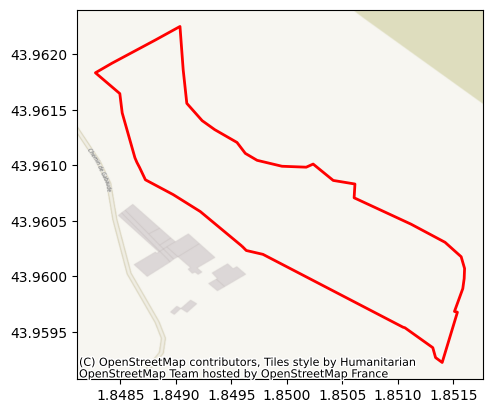

In [9]:
sample_idx = choice(rpg_gdf.index)
sample_poly = rpg_gdf.iloc[sample_idx]["geometry"]
sample_poly_gdf = gpd.GeoDataFrame({'geometry': [sample_poly]}, crs='epsg:4326')
print(sample_poly.centroid.x, sample_poly.centroid.y)

ax = sample_poly_gdf.plot(edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax=ax, crs=rpg_gdf.crs)

C:\Users\matth\AppData\Local\Temp\ipykernel_15396\1582178984.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  rpg_gdf.centroid.plot(ax=ax, edgecolor='black', facecolor='black')
C:\Users\matth\AppData\Local\Temp\ipykernel_15396\1582178984.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sample_poly_gdf.centroid.plot(ax=ax, edgecolor='red', facecolor='red')


<Axes: >

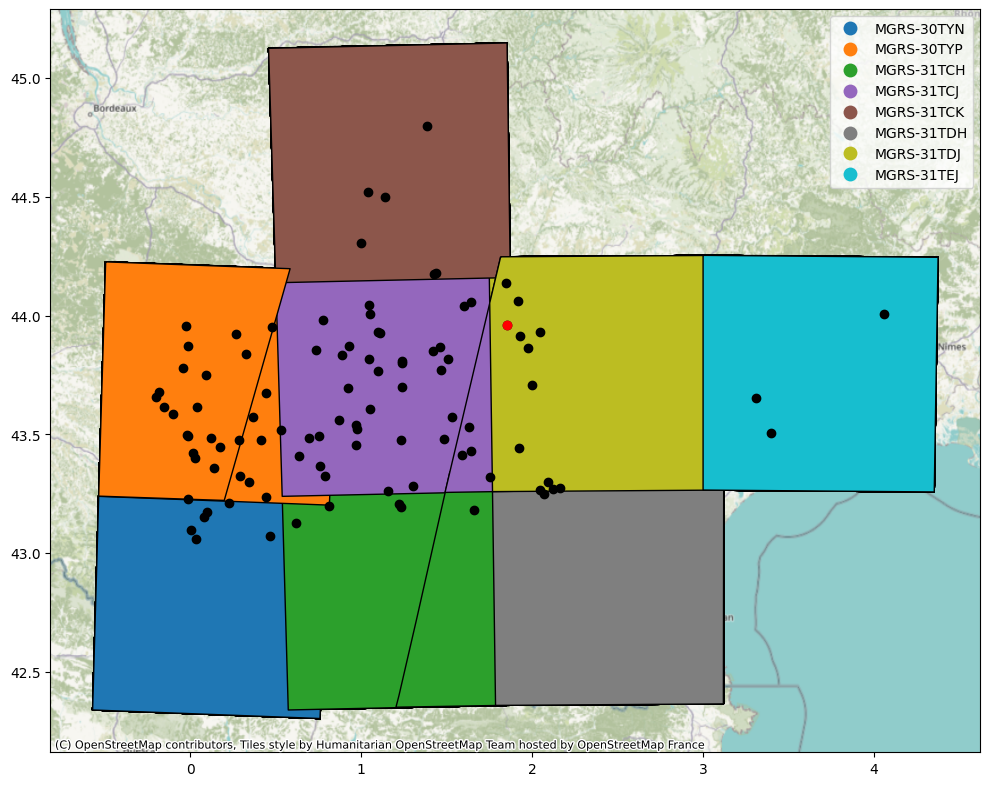

In [10]:
ax = sentinel_gdf.plot(column="grid:code", edgecolor="k", figsize=(12, 12), legend=True)
cx.add_basemap(ax=ax, crs=sentinel_gdf.crs)
rpg_gdf.centroid.plot(ax=ax, edgecolor='black', facecolor='black')
sample_poly_gdf.centroid.plot(ax=ax, edgecolor='red', facecolor='red')

In [11]:
sample_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])

table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in sample_item.assets.items():
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key         ┃ Description                     ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ aot               │ Aerosol optical thickness (AOT) │
│ blue              │ Blue (band 2) - 10m             │
│ coastal           │ Coastal aerosol (band 1) - 60m  │
│ granule_metadata  │                                 │
│ green             │ Green (band 3) - 10m            │
│ nir               │ NIR 1 (band 8) - 10m            │
│ nir08             │ NIR 2 (band 8A) - 20m           │
│ nir09             │ NIR 3 (band 9) - 60m            │
│ red               │ Red (band 4) - 10m              │
│ rededge1          │ Red edge 1 (band 5) - 20m       │
│ rededge2          │ Red edge 2 (band 6) - 20m       │
│ rededge3          │ Red edge 3 (band 7) - 20m       │
│ scl               │ Scene classification map (SCL)  │
│ swir16            │ SWIR 1 (band 11) - 20m          │
│ swir22            │ SWIR 2 (band 12) - 20m          │
│ thumbnail         │ Thumbnail image                 │
│ tileinfo_metadata │                                 │
│ visual            │ True color image                │
│ wvp               │ Water vapour (WVP)              │
│ aot-jp2           │ Aerosol optical thickness (AOT) │
│ blue-jp2          │ Blue (band 2) - 10m             │
│ coastal-jp2       │ Coastal aerosol (band 1) - 60m  │
│ green-jp2         │ Green (band 3) - 10m            │
│ nir-jp2           │ NIR 1 (band 8) - 10m            │
│ nir08-jp2         │ NIR 2 (band 8A) - 20m           │
│ nir09-jp2         │ NIR 3 (band 9) - 60m            │
│ red-jp2           │ Red (band 4) - 10m              │
│ rededge1-jp2      │ Red edge 1 (band 5) - 20m       │
│ rededge2-jp2      │ Red edge 2 (band 6) - 20m       │
│ rededge3-jp2      │ Red edge 3 (band 7) - 20m       │
│ scl-jp2           │ Scene classification map (SCL)  │
│ swir16-jp2        │ SWIR 1 (band 11) - 20m          │
│ swir22-jp2        │ SWIR 2 (band 12) - 20m          │
│ visual-jp2        │ True color image                │
│ wvp-jp2           │ Water vapour (WVP)              │
└───────────────────┴─────────────────────────────────┘

In [12]:
xx = stac_load(items, 
               bands=["scl", "nir", "red", "swir16"], 
               crs="epsg:4326", 
               resolution=0.0001, 
               chunks={}, 
               groupby="solar_day",
               geopolygon=sample_poly)


In [13]:
xx["nir"] = xx.nir.astype(int)
xx["red"] = xx.red.astype(int)
xx["swir16"] = xx.swir16.astype(int)

xx["ndvi"] = (xx.nir - xx.red) / (xx.nir + xx.red)
xx["ndmi"] = (xx.nir - xx.swir16) / (xx.nir + xx.swir16)
xx

<xarray.Dataset> Size: 9MB
Dimensions:      (latitude: 31, longitude: 35, time: 212)
Coordinates:
  * latitude     (latitude) float64 248B 43.96 43.96 43.96 ... 43.96 43.96 43.96
  * longitude    (longitude) float64 280B 1.848 1.848 1.848 ... 1.852 1.852
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 2kB 2023-01-02T10:48:53.507000 ... 202...
Data variables:
    scl          (time, latitude, longitude) uint8 230kB dask.array<chunksize=(1, 31, 35), meta=np.ndarray>
    nir          (time, latitude, longitude) int64 2MB dask.array<chunksize=(1, 31, 35), meta=np.ndarray>
    red          (time, latitude, longitude) int64 2MB dask.array<chunksize=(1, 31, 35), meta=np.ndarray>
    swir16       (time, latitude, longitude) int64 2MB dask.array<chunksize=(1, 31, 35), meta=np.ndarray>
    ndvi         (time, latitude, longitude) float64 2MB dask.array<chunksize=(1, 31, 35), meta=np.ndarray>
    ndmi         (time, latitude, longitude) float64 2MB dask.array<chunksize=(1, 31, 35), meta=np.ndarray>

In [14]:
ShapeMask = geometry_mask([sample_poly],
                          out_shape=(len(xx.latitude), len(xx.longitude)),
                          transform=xx.odc.geobox.transform,
                          invert=True)
ShapeMask = xr.DataArray(ShapeMask , dims=("latitude", "longitude"))

xx = xx.where(ShapeMask == True, drop=True)

In [15]:
%%time
xx = xx.compute()

C:\Users\matth\AppData\Local\pypoetry\Cache\virtualenvs\src-bOYfMffE-py3.11\Lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
C:\Users\matth\AppData\Local\pypoetry\Cache\virtualenvs\src-bOYfMffE-py3.11\Lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: total: 5.47 s
Wall time: 58.3 s


In [16]:
# https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/
xx = xx.where(xx.scl.isin([4,5,6,7]), drop=True)
xx

<xarray.Dataset> Size: 3MB
Dimensions:      (time: 66, latitude: 29, longitude: 33)
Coordinates:
  * latitude     (latitude) float64 232B 43.96 43.96 43.96 ... 43.96 43.96 43.96
  * longitude    (longitude) float64 264B 1.848 1.848 1.849 ... 1.851 1.852
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 528B 2023-01-05T10:58:43.261000 ... 20...
Data variables:
    scl          (time, latitude, longitude) float32 253kB nan nan ... nan nan
    nir          (time, latitude, longitude) float64 505kB nan nan ... nan nan
    red          (time, latitude, longitude) float64 505kB nan nan ... nan nan
    swir16       (time, latitude, longitude) float64 505kB nan nan ... nan nan
    ndvi         (time, latitude, longitude) float64 505kB nan nan ... nan nan
    ndmi         (time, latitude, longitude) float64 505kB nan nan ... nan nan

In [17]:
time_values = xx['time'].values

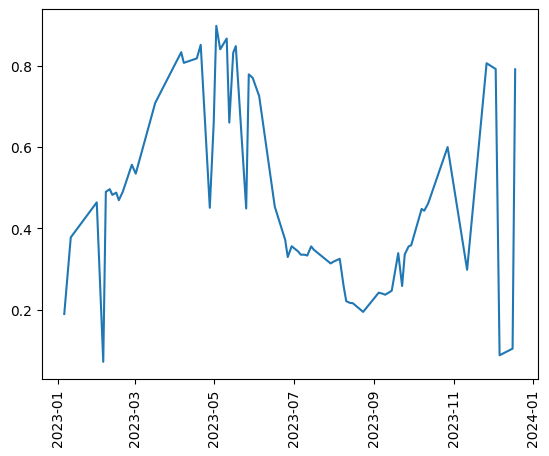

In [18]:
mean_ndvis = []
for t in time_values:
    ndvi_t = xx.sel(time=t)['ndvi']
    mean_ndvi_t = ndvi_t.mean(dim=['latitude', 'longitude'], skipna=True)
    mean_ndvis.append(mean_ndvi_t)
    
plt.plot(time_values, mean_ndvis)
ax = plt.xticks(rotation=90)

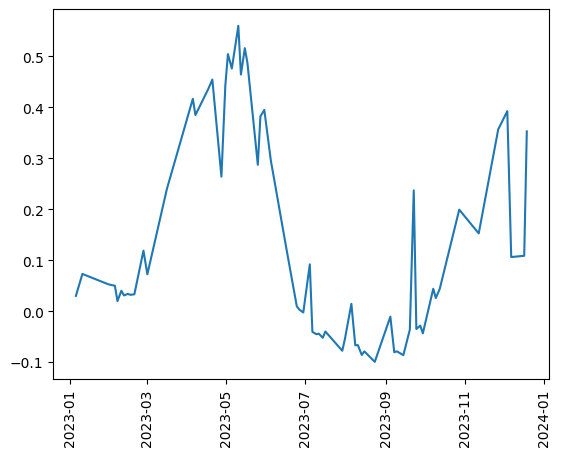

In [19]:
mean_ndmis = []
for t in time_values:
    ndmi_t = xx.sel(time=t)['ndmi']
    mean_ndmi_t = ndmi_t.mean(dim=['latitude', 'longitude'], skipna=True)
    mean_ndmis.append(mean_ndmi_t)
    
plt.plot(time_values, mean_ndmis)
ax = plt.xticks(rotation=90)

In [20]:
xx_mean_ndvi_min = xx.sel(time=min(mean_ndvis).time)
xx_mean_ndvi_max = xx.sel(time=max(mean_ndvis).time)

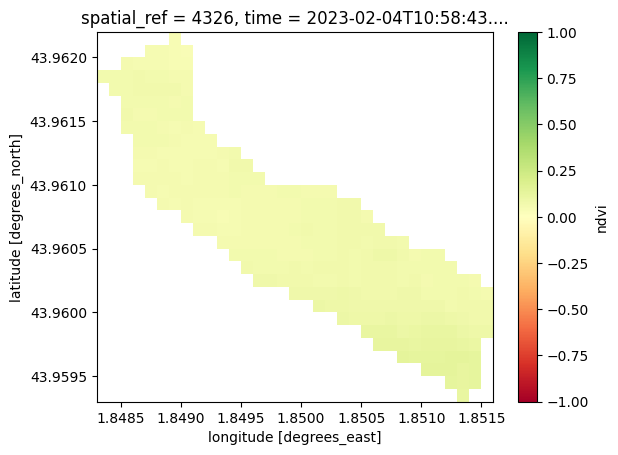

In [21]:
xx_mean_ndvi_min.ndvi.plot(vmin=-1, vmax=1, cmap="RdYlGn")

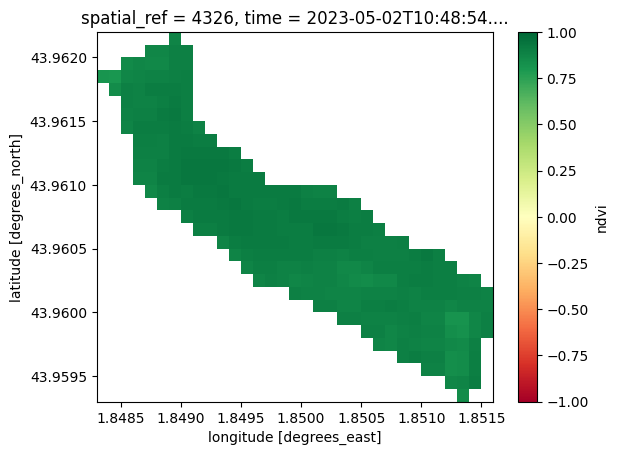

In [22]:
xx_mean_ndvi_max.ndvi.plot(vmin=-1, vmax=1, cmap="RdYlGn")

In [23]:
xx_mean_ndmi_min = xx.sel(time=min(mean_ndmis).time)
xx_mean_ndmi_max = xx.sel(time=max(mean_ndmis).time)

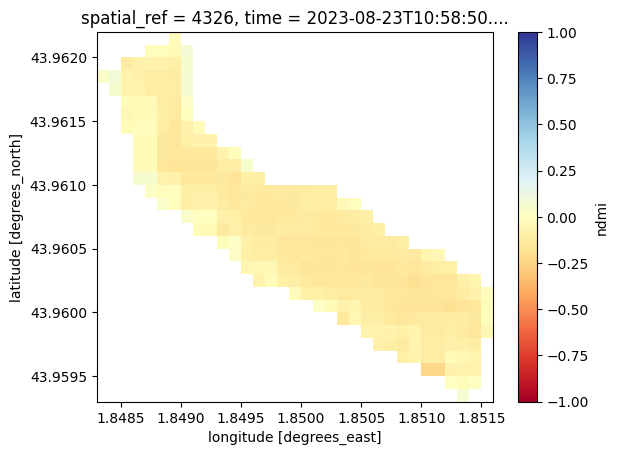

In [24]:
xx_mean_ndmi_min.ndmi.plot(vmin=-1, vmax=1, cmap="RdYlBu")

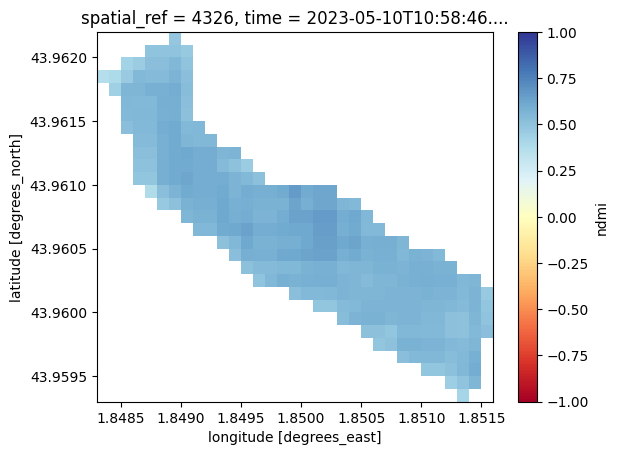

In [25]:
xx_mean_ndmi_max.ndmi.plot(vmin=-1, vmax=1, cmap="RdYlBu")